In this notebook we will load a sample from a full length movie and demonstrate how to make time projection and then use cellpose to make segmentation masks. This will give us the motion of the nuclei/cell and hence overall area in which the nuclei can be found over the length of the movie

## Import all necessary libraries 

In [1]:
import os
import math
import napari
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from cellpose import models
from imaris_ims_file_reader.ims import ims
from dask.array.image import imread as imr
from cellpose.io import imread, save_to_png, masks_flows_to_seg, imsave

In [2]:
def get_model():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askopenfilename(initialdir= "/", title='Please select a movie')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path

def choose_home_folder():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askdirectory(initialdir= "/", title='Please select a directory')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path

## Load pretrained cellpose model 

In [3]:
liveCellModel = models.CellposeModel(pretrained_model=get_model())#/overnight/tProjections/models/vera_5/')

In [6]:
identifier = input('Enter an identifier for the movie : ')

Enter an identifier for the movie : TNF


##  Specify path to input and output


In [8]:
homeFolder0 = choose_home_folder()
homeFolder = [homeFolder0+'/'+i for i in os.listdir(homeFolder0) if identifier in i and os.path.isdir(os.path.join(homeFolder0,i))]
homeFolder.sort()
homeFolder

['C:/Users/uid-1204/Desktop/test2_bigFISHLIVE/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06']

In [9]:
pathToTProjections = os.path.join(homeFolder0+'/tProjections/')
try:
    os.makedirs(pathToTProjections)
except FileExistsError:
   # directory already exists
   pass

## Run Bulk


C:/Users/uid-1204/Desktop/test2_bigFISHLIVE/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06/*.tif
Movie folder found Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06
Shape of the movie data (t,z,y,x): (900, 13, 1024, 1024)
Time Projection Saved!
Segmentation Results Saved!


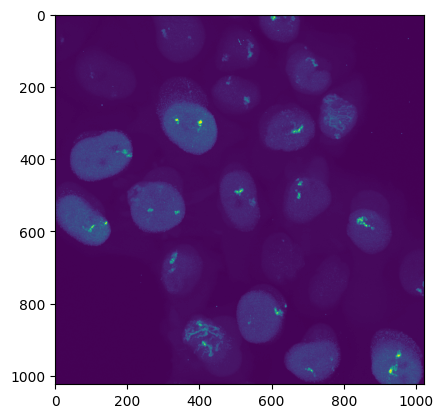

In [10]:
for sessionName in homeFolder:
    pathToTimeFrames = os.path.join(homeFolder0,sessionName+'/*.tif')
    print(pathToTimeFrames)
    movieName = pathToTimeFrames.split('/')[-2]
    print('Movie folder found', movieName)
    timeStack = imr(pathToTimeFrames)
    print('Shape of the movie data (t,z,y,x):', timeStack.shape)
    
    # Make time projection 
    
    maxImage = np.max(timeStack, axis=1)
    MaxTimePoint=timeStack.shape[0]
    TimeProjection = np.max(maxImage, axis=0)

    # Save time projection for later use

    with tifffile.TiffWriter(pathToTProjections+'T_MAX_'+ movieName.replace('.','_') +'.tif', imagej=True) as tif:
                tif.write(TimeProjection)
    print('Time Projection Saved!')
            
    # Verify time projection
    
    timeProject = imread(pathToTProjections+'/T_MAX_'+ movieName.replace('.','_') +'.tif')
    plt.figure()
    plt.imshow(timeProject)
    
    # Segmentation using Cellpose 
    # Specify model parameters

    imgs = timeProject
    nimg = len(imgs)
    channels = [[0,0]]

    # Segmentation

    masks, flows, styles = liveCellModel.eval(imgs, diameter=None, channels=channels)

    # Save segmentation Results

    masks_flows_to_seg(imgs, masks, flows,pathToTProjections+'T_MAX_'+movieName.replace('.','_'),  1, channels)
    save_to_png(imgs, masks, flows, pathToTProjections+'T_MAX_'+movieName.replace('.','_'))
    print('Segmentation Results Saved!')

## Visualise Results 

In [13]:
sessionName = homeFolder[0]

pathToTimeFrames = os.path.join(homeFolder0,sessionName+'/*.tif')
print(pathToTimeFrames)
movieName = pathToTimeFrames.split('/')[-2]
# Load saved mask
timeStack = imr(pathToTimeFrames)
maxImage = np.max(timeStack, axis=1)
label_image_name = pathToTProjections+'T_MAX_'+movieName.replace('.','_')+'_cp_masks.png'

label_image = imread(label_image_name)
print(label_image_name)
viewer = napari.Viewer()

image_layer = viewer.add_image(
        maxImage, colormap='green' #maxImageCell
        )
labels_layer = viewer.add_labels(label_image, name='segmentation',opacity=0.3)

C:/Users/uid-1204/Desktop/test2_bigFISHLIVE/Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06/*.tif
C:/Users/uid-1204/Desktop/test2_bigFISHLIVE/tProjections/T_MAX_Hela_h9_h2_k11_mcpsg_1hrbasal_14hr_TNF_TSA_exp2_2_F06_cp_masks.png


## Save mask

In [14]:
imsave(label_image_name,viewer.layers['segmentation'].data)